In [3]:
import numpy as np
from utils import get_and_fit_gp, ModelListGP
import matplotlib.pyplot as plt
from matplotlib import ticker
import pickle
import torch

plt.rcParams.update({'font.size': 22})

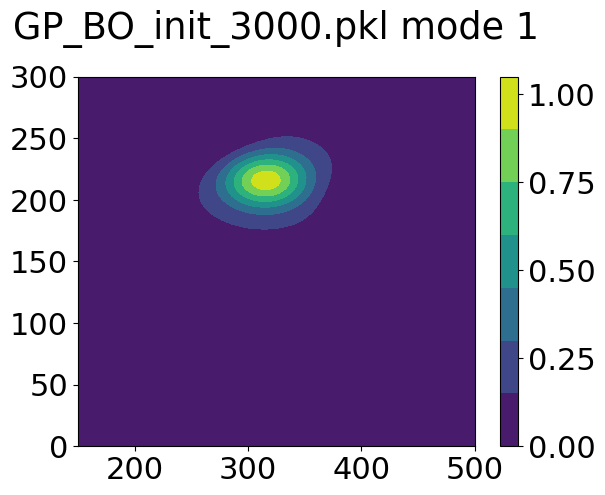

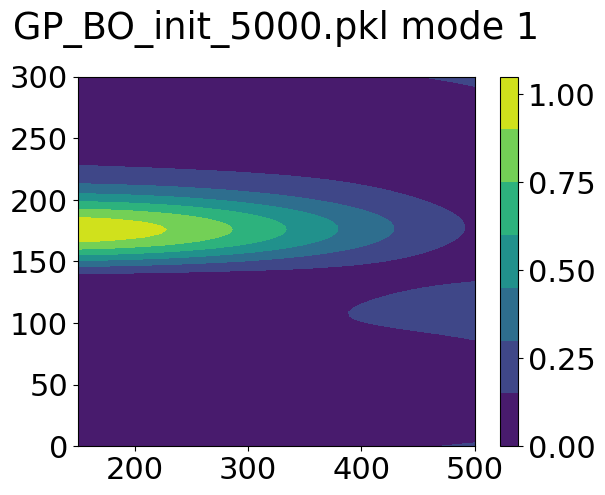

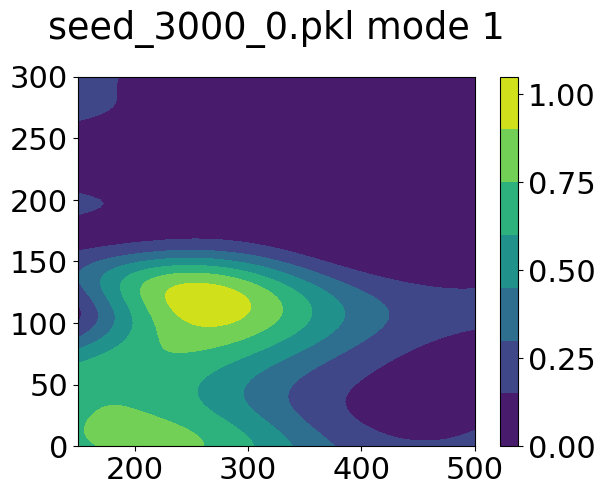

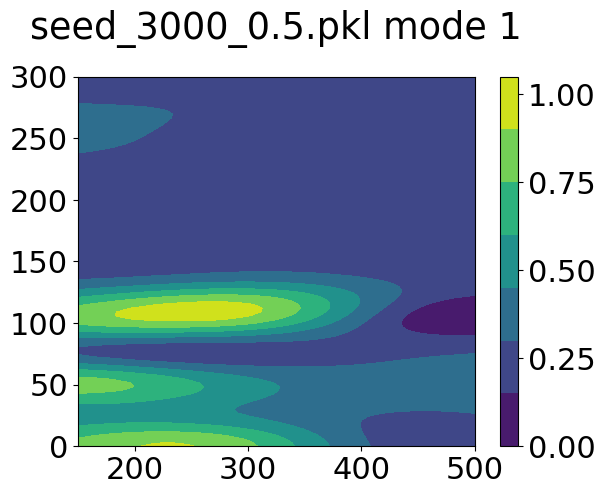

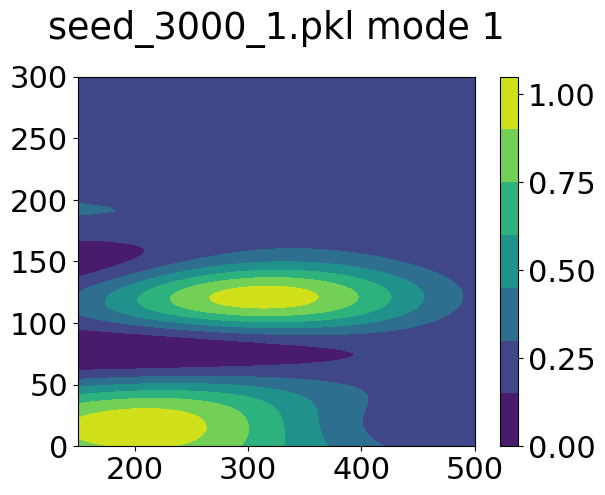

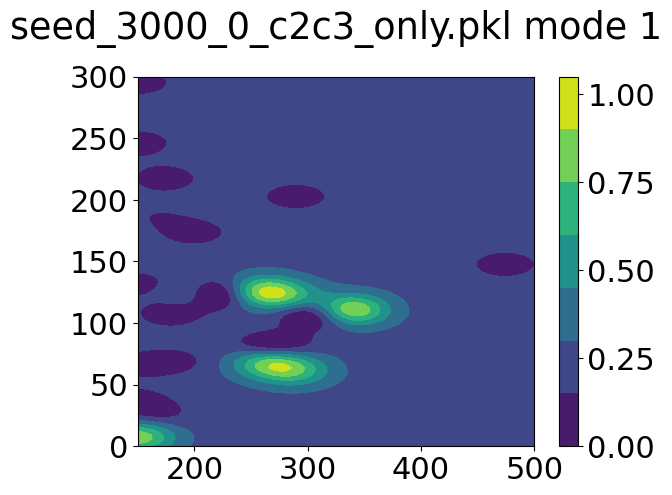

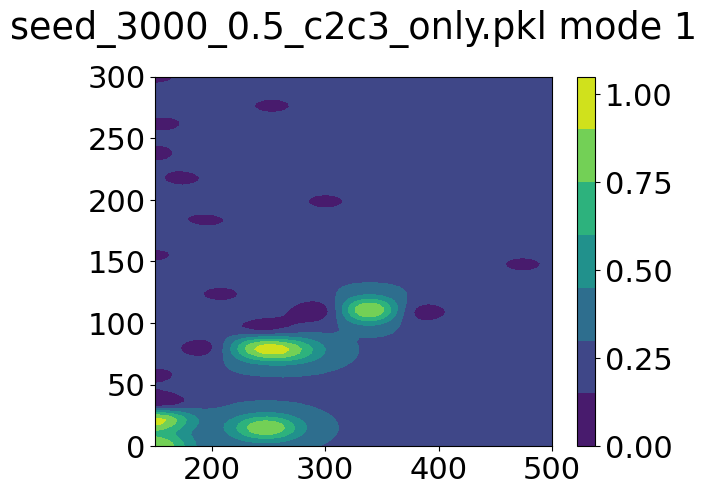

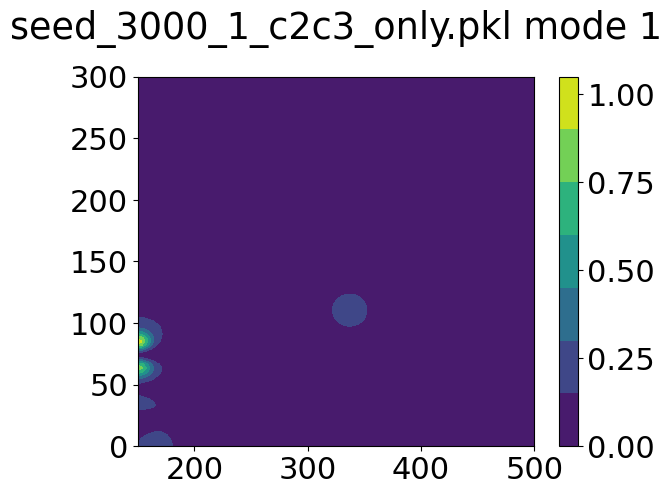

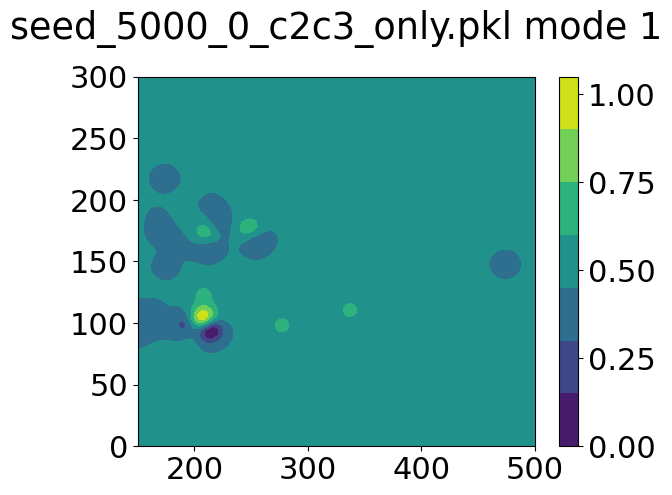

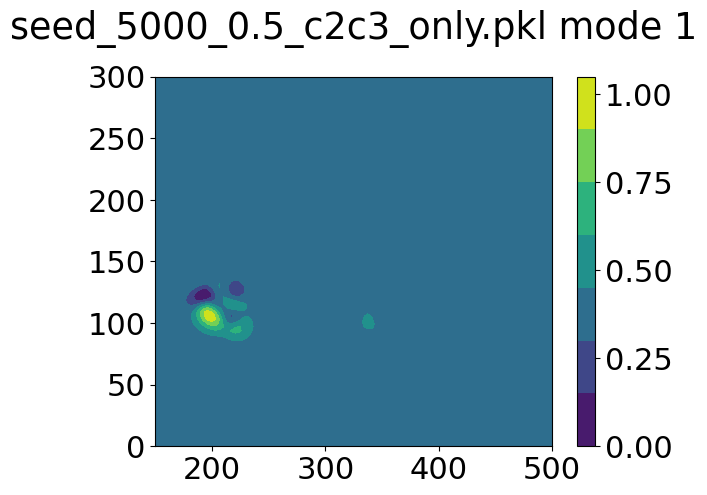

In [ ]:
N=100   

def unnormalize(X):
    return (X[0]*350+150,X[1]*300) # Unnormalize [0,1]X[0,1] to [100,400]X[100,400]

def unnormalize_x(x):
    return x*350+150

def unnormalize_y(y):
    return y*300

plt.gca().set_aspect("equal")

def plot_cost_contour(path, mode, unnormalize=False, title=None):

    with open(path, 'rb') as f:
        data = pickle.load(f)

    Y = data['y_data'].double().detach()
    X = data['X'].double().detach() if torch.is_tensor(data['X']) else torch.tensor(data['X'], dtype=torch.float64).detach()
    Y = Y[:len(X),:]
    X = X[:len(Y),:]
    # print(X.size(), Y.size())

    # print(Y)
    if Y.shape[-1] == 3:
        Y = torch.index_select(Y, 1, torch.LongTensor([1,2,0]))
    # print(Y)

    gp_models = [
        get_and_fit_gp(X,  Y[:, i : i + 1].reshape(-1,1)) 
        for i in range(Y.shape[-1])
    ]

    # for im in range(len(gp_models)):
    for im in (mode-1,):

        model = gp_models[im]

        model.eval()
        test_points = []
        test_interval = np.linspace(0, 1, N)

        for i in test_interval:
                for j in test_interval:
                        test_points.append([i, j])

        test_points = torch.tensor(test_points)
        post = model.posterior(test_points.float())
        mean = post.mean.detach().cpu().numpy().reshape((N,N))

        mean = (mean - np.min(mean))/np.ptp(mean) # rescale to 0, 1
        # mean = mean.clip(0,1) # other option

        plt.clf()

        if unnormalize:
            xpl = unnormalize_x(test_interval)
            ypl = unnormalize_y(test_interval)
        else:
            xpl = test_interval
            ypl = test_interval

        fig = plt.contourf(xpl,ypl,mean)
        if title is None:
            title = f'{path} mode {int(im+1)}'
        plt.title(title, y=1.08)

        cb = plt.colorbar()
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()

        fname = title.replace(" ", "_")
        plt.savefig(f'plots/{fname}.png', bbox_inches='tight')

        plt.show(fig)


types = ('init', 'all', 'c2c3', 'w/c1')

suffixes = {
    'all': "",
    'c2c3': "_c2c3_only",
    'w/c1': "_with_c1"
}

seeds = {
    'init': (3000, 5000),
    'all': (3000,),
    'c2c3': (3000, 5000, 10000),
    'w/c1': (3000,),
}

modes_to_types = {
    3: ('init', 'all', 'w/c1'),
    1: types,
    2: types,
}

lambdas = (0, 0.5, 1)

paths_modes = []
for mode in (1, 2, 3):
    for t in modes_to_types[mode]:
        if t == 'init':
            for seed in seeds[t]:
                paths_modes.append((f'GP_BO_init_{seed}.pkl', mode))
        else:
            for seed in seeds[t]:
                for l in lambdas:
                    paths_modes.append((f'seed_{seed}_{l}{suffixes[t]}.pkl', mode))
# print (paths)

for path, mode in paths_modes:
    plot_cost_contour(path, mode, unnormalize=True)


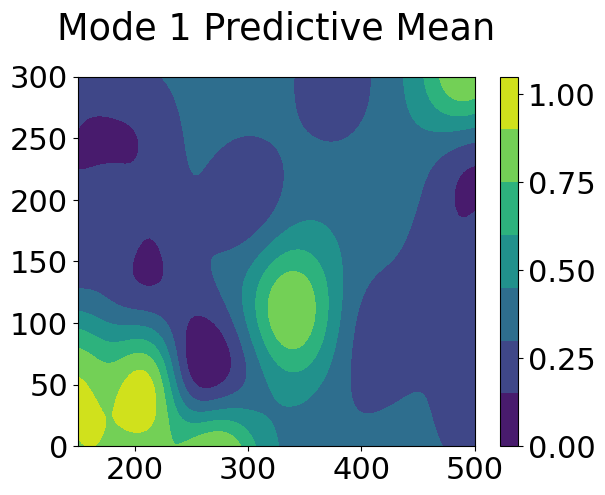

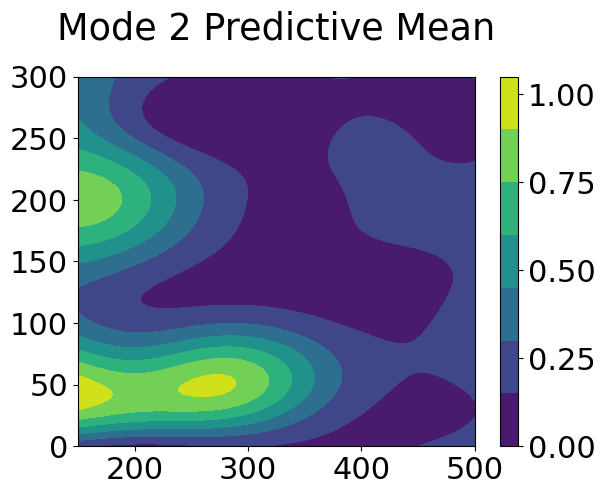

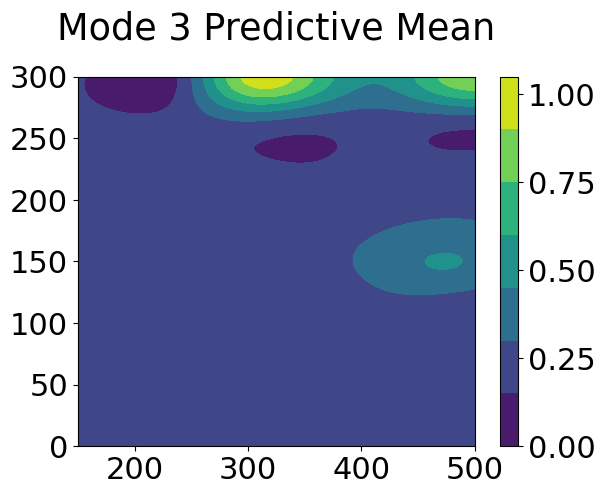

In [12]:
# 1: seed 5000 1 c2c3 mode 1
# 2: seed 5000 1 c2c3 mode 2
# 3: seed 3000 1 mode 3 

plot_list = [
    ('seed_5000_1_c2c3_only.pkl', 1, 'Mode 1 Predictive Mean'),
    ('seed_5000_1_c2c3_only.pkl', 2, 'Mode 2 Predictive Mean'),
    ('seed_3000_1.pkl', 3, 'Mode 3 Predictive Mean'),
]

for path, mode, title in plot_list:
    plot_cost_contour(path, mode, unnormalize=True, title=title)